In [1]:
import my_functions as my
%pylab inline

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(interval=1)  # every month
weeks = mdates.WeekdayLocator(byweekday=mdates.MO, interval=2)
week = mdates.WeekdayLocator(byweekday=mdates.MO, interval=1)
yearsFmt = mdates.DateFormatter("%d.%m")

import glidertools as gt
import xarray as xr
import numpy as np

import cmocean.cm as cmo

matplotlib.rcParams['figure.figsize'] = (18,10)
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.direction'] = 'in'

font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 12}

matplotlib.rc('font', **font)

matplotlib.rc('ytick.major', size=6)
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('ytick.minor', size=4)
matplotlib.rc('xtick.minor', size=4)
matplotlib.rc('lines', linewidth=2.5)

Populating the interactive namespace from numpy and matplotlib


#### Load the glider data

In [2]:
interp_res = '1D'
offset     = '12H'
dt=86400

dat_saz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/sg542_saz_L2.nc')
dat_apz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/slocum_apz_L2.nc')
dat_miz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/sg643_miz_L2.nc')

dat_saz_interp = dat_saz.resample(time=interp_res, loffset=offset).mean()
dat_apz_interp = dat_apz.resample(time=interp_res, loffset=offset).mean()
dat_miz_interp = dat_miz.resample(time=interp_res, loffset=offset).mean()

dat_saz_interp=dat_saz_interp.interpolate_na(dim='time')
dat_apz_interp=dat_apz_interp.interpolate_na(dim='time')
dat_miz_interp=dat_miz_interp.interpolate_na(dim='time')

#### Load ERA5

In [3]:
import my_functions as my

era5 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/ERA5_flux_data/*.nc')
era5 = era5.sel(latitude=slice(-40, -65), longitude=slice(-30, 30))

# convert from J m-2 to W m-2
var_name=['slhf', 'sshf', 'str', 'ssr', 'tp', 'e']
era5=my.convert_era5_to_Wm2(ds=era5, var_name=var_name)

# calculate net fluxes and emp
era5['emp']  = (('time', 'latitude', 'longitude'), era5['e']-era5['tp'])
era5['qnet'] = (('time', 'latitude', 'longitude'), era5['slhf']+era5['sshf']+era5['str']+era5['ssr'])

# interp to the resolution of the glider
era5_interp = era5.resample(time=interp_res, loffset=offset).mean()

#### Load JRA55

In [4]:
ep_jra55 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/precipitation_evaporation/JRA55/*.nc')
hf_jra55 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/heat_flux/JRA55/*.nc')
ws_jra55 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/wind_speed/JRA55/*.nc')

# merge the datasets
jra55 = xr.merge([ep_jra55, hf_jra55, ws_jra55])

# correct the longitudes
jra55 = my.adjust_lon_xr_dataset(jra55, lon_name='g4_lon_2')

# Change to consisent naming convention for longitude and latitudes
jra55 = jra55.rename({'g4_lat_1'           : 'latitude',
                      'g4_lon_2'           : 'longitude',
                      'initial_time0_hours': 'time'})

# rename variables
jra55 = jra55.rename({
                      'LHTFL_GDS4_SFC_ave3h': 'slhf',
                      'SHTFL_GDS4_SFC_ave3h': 'sshf',
                      'DSWRF_GDS4_SFC_ave3h': 'dssr',
                      'USWRF_GDS4_SFC_ave3h': 'ussr',
                      'DLWRF_GDS4_SFC_ave3h': 'dstr',
                      'ULWRF_GDS4_SFC_ave3h': 'ustr',
                      'EVP_GDS4_SFC_ave3h'  : 'e',
                      'TPRAT_GDS4_SFC_ave3h': 'tp',
                      'UGRD_GDS4_HTGL'      : 'u10',
                      'VGRD_GDS4_HTGL'      : 'v10',})

jra55 = jra55.sel(latitude=slice(-40, -65), longitude=slice(-30, 30))

jra55['e']  = (('time', 'latitude', 'longitude'), -jra55['e']/(86400*1000))
jra55['tp'] = (('time', 'latitude', 'longitude'),  jra55['tp']/(86400*1000))

jra55['ssr'] = (('time', 'latitude', 'longitude'),  jra55['dssr']-jra55['ussr'])
jra55['str'] = (('time', 'latitude', 'longitude'),  jra55['dstr']-jra55['ustr'])

jra55['sshf'] = (('time', 'latitude', 'longitude'),  -jra55['sshf'])
jra55['slhf'] = (('time', 'latitude', 'longitude'),  -jra55['slhf'])

# calculate net fluxes and emp
jra55['emp']  = (('time', 'latitude', 'longitude'), jra55['e']   -jra55['tp'])
jra55['qnet'] = (('time', 'latitude', 'longitude'), jra55['slhf']+jra55['sshf']+jra55['str']+jra55['ssr'])

# interp to the resolution of the glider
jra55_interp = jra55.resample(time=interp_res, loffset=offset).mean()

#### Load MERRA2

In [5]:
ep_merra = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/precipitation_evaporation/MERRA2/*.nc4')
hf_merra = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/heat_flux/MERRA2/*.nc4')
ws_merra = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/wind_speed/MERRA2/*.nc4')

# merge the datasets
merra = xr.merge([ep_merra, hf_merra, ws_merra])
merra = merra.sel(lat=slice(-65, -40), lon=slice(-30, 30))

# correct the longitudes
merra = my.adjust_lon_xr_dataset(merra, lon_name='lon')

# Change to consisent naming convention for longitude and latitudes
merra = merra.rename({'lat': 'latitude',
                    'lon': 'longitude'})

# rename variables
merra = merra.rename({
                    'EFLUX'  : 'slhf',
                    'HFLUX'  : 'sshf',
                    'SWGNT'  : 'ssr',
                    'LWGNT'  : 'str',
                    'EVAP'   : 'e',
                    'PRECTOT': 'tp',
                    'U10M'   : 'u10',
                    'V10M'   : 'v10'})

merra['e']  = (('time', 'latitude', 'longitude'), -merra['e']/(1025))
merra['tp']  = (('time', 'latitude', 'longitude'), merra['tp']/(1025))

merra['sshf'] = (('time', 'latitude', 'longitude'),  -merra['sshf'])
merra['slhf'] = (('time', 'latitude', 'longitude'),  -merra['slhf'])

# calculate net fluxes and emp
merra['emp']  = (('time', 'latitude', 'longitude'), merra['e']   -merra['tp'])
merra['qnet'] = (('time', 'latitude', 'longitude'), merra['slhf']+merra['sshf']+merra['str']+merra['ssr'])

# interp to the resolution of the glider
merra_interp = merra.resample(time=interp_res, loffset=offset).mean()

In [6]:
# interpolate to the nearest location of the glider
from tqdm import tqdm

var_name = ['slhf','sshf','str' ,'ssr' ,'tp' ,'e' ,'emp' , 'u10', 'v10', 'qnet']

for var in tqdm(var_name):
  
    dat_saz_interp[var+'_era5'] = (('time'), my.interp_glider_era5(dat_saz_interp, era5_interp, var=var))
    dat_apz_interp[var+'_era5'] = (('time'), my.interp_glider_era5(dat_apz_interp, era5_interp, var=var))
    dat_miz_interp[var+'_era5'] = (('time'), my.interp_glider_era5(dat_miz_interp, era5_interp, var=var))
    
    dat_saz_interp[var+'_merra'] = (('time'), my.interp_glider_era5(dat_saz_interp, merra_interp, var=var))
    dat_apz_interp[var+'_merra'] = (('time'), my.interp_glider_era5(dat_apz_interp, merra_interp, var=var))
    dat_miz_interp[var+'_merra'] = (('time'), my.interp_glider_era5(dat_miz_interp, merra_interp, var=var))
    
    dat_saz_interp[var+'_jra55'] = (('time'), my.interp_glider_era5(dat_saz_interp, jra55_interp, var=var))
    dat_apz_interp[var+'_jra55'] = (('time'), my.interp_glider_era5(dat_apz_interp, jra55_interp, var=var))
    dat_miz_interp[var+'_jra55'] = (('time'), my.interp_glider_era5(dat_miz_interp, jra55_interp, var=var))

100%|██████████| 10/10 [04:52<00:00, 29.24s/it]


### Figure compare

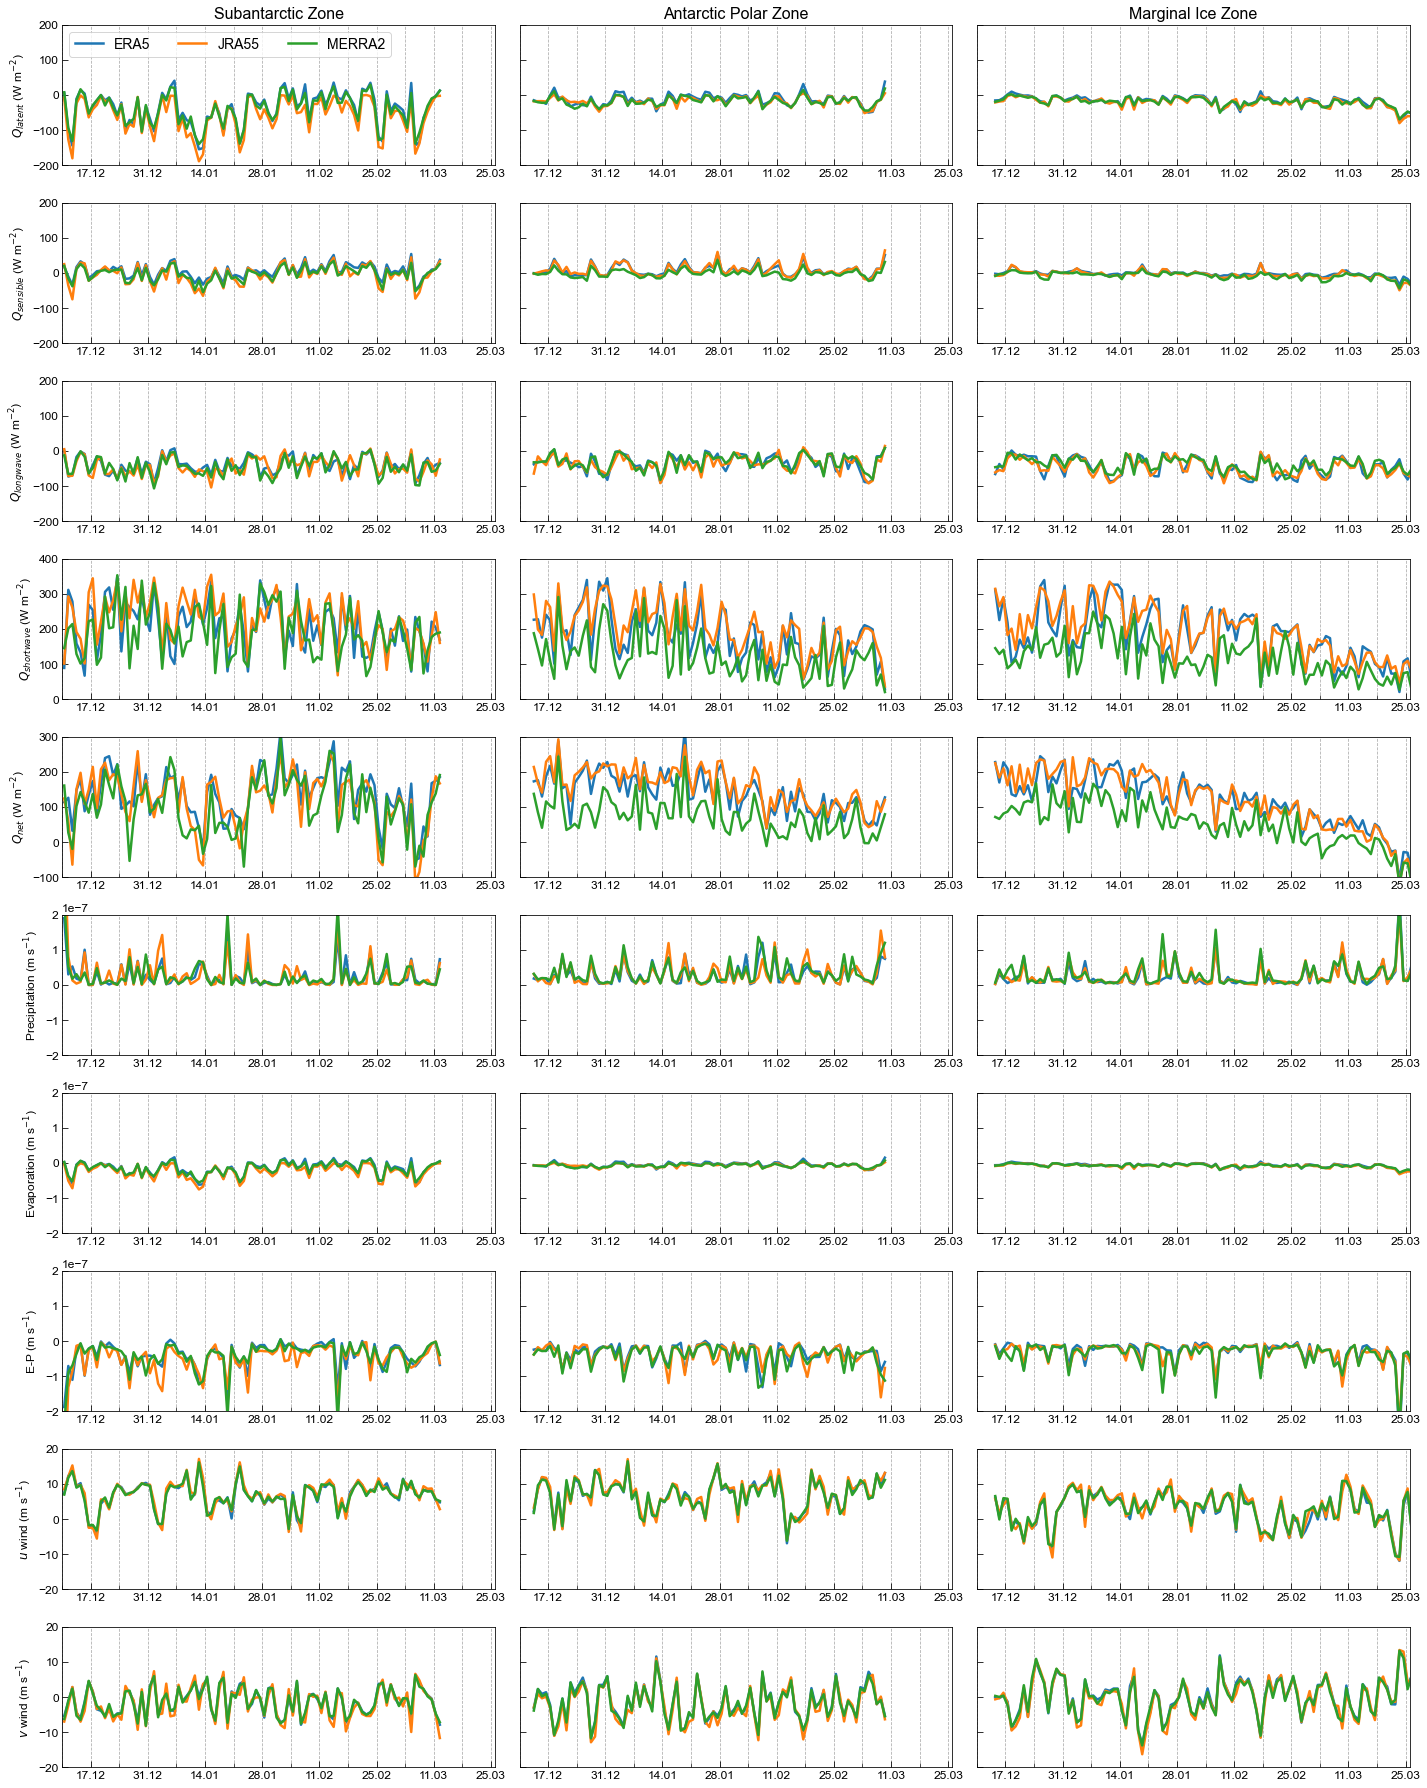

In [76]:
nrow=10
ncol=3

fig,ax=subplots(nrow, ncol, figsize=[20, 25])
fig.subplots_adjust(wspace=0.1)

var_name = ['slhf','sshf','str' ,'ssr', 'qnet' ,'tp' ,'e' ,'emp' , 'u10', 'v10']

for d, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):

    for i in range(nrow):
        
        ax[i,d].plot(dat.time, dat[var_name[i]+'_era5'] , label='ERA5')
        ax[i,d].plot(dat.time, dat[var_name[i]+'_jra55'], label='JRA55')
        ax[i,d].plot(dat.time, dat[var_name[i]+'_merra'], label='MERRA2')
        
        ax[i,d].set_xlim('2018-12-10', '2019-03-26')
        
        ax[i,d].xaxis.set_major_locator(weeks)
        ax[i,d].xaxis.set_minor_locator(week)
        ax[i,d].xaxis.set_major_formatter(yearsFmt)
        ax[i,d].grid(ls='--', which='both', axis='x')

for d in range(3):
    
    ax[0,d].set_ylim(-200, 200);  ax[0,d].yaxis.set_ticks(np.arange(-200, 300, 100))
    ax[1,d].set_ylim(-200, 200);  ax[1,d].yaxis.set_ticks(np.arange(-200, 300, 100))
    ax[2,d].set_ylim(-200, 200);  ax[2,d].yaxis.set_ticks(np.arange(-200, 300, 100))
    ax[3,d].set_ylim(   0, 400);  ax[3,d].yaxis.set_ticks(np.arange(   0, 500, 100))
    ax[4,d].set_ylim(-100, 300);  ax[4,d].yaxis.set_ticks(np.arange(-100, 400, 100))
    ax[5,d].set_ylim(-2e-7, 2e-7);  ax[5,d].yaxis.set_ticks(np.arange(-2e-7, 3e-7, 1e-7))
    ax[6,d].set_ylim(-2e-7, 2e-7);  ax[6,d].yaxis.set_ticks(np.arange(-2e-7, 3e-7, 1e-7))
    ax[7,d].set_ylim(-2e-7, 2e-7);  ax[7,d].yaxis.set_ticks(np.arange(-2e-7, 3e-7, 1e-7))
    ax[8,d].set_ylim(-20, 20);  ax[8,d].yaxis.set_ticks(np.arange(-20, 30, 10))
    ax[9,d].set_ylim(-20, 20);  ax[9,d].yaxis.set_ticks(np.arange(-20, 30, 10))
    
    if d > 0:
        
        for i in range(10):
            
            ax[i,d].yaxis.set_ticklabels([]);
            ax[i,d].yaxis.set_ticklabels([]);

ax[0,0].legend(loc=2, ncol=3, fontsize=14)

var_name = ['$Q_{latent}$ (W m$^{-2}$)','$Q_{sensible}$ (W m$^{-2}$)','$Q_{longwave}$ (W m$^{-2}$)' ,'$Q_{shortwave}$ (W m$^{-2}$)', '$Q_{net}$ (W m$^{-2}$)' ,'Precipitation (m s$^{-1}$)' ,'Evaporation (m s$^{-1}$)' ,'E-P (m s$^{-1}$)' , '$u$ wind (m s$^{-1}$)', '$v$ wind (m s$^{-1}$)']


for r in range(10):
    
    ax[r,0].set_ylabel(var_name[r])
    
ax[0,0].set_title('Subantarctic Zone'   , fontsize=16)
ax[0,1].set_title('Antarctic Polar Zone', fontsize=16)
ax[0,2].set_title('Marginal Ice Zone'   , fontsize=16)

fig.tight_layout()

savefig('../../figures/reanalysis_comparisons_colocated.png', dpi=300)

In [7]:
import airsea

reanalysis =['era5', 'jra55', 'merra']

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    for r in reanalysis:

        dat['taux_'+str(r)] = (('time'), airsea.windstress.stress(dat['u10_'+str(r)], z=10., drag='largepond', rho_air=1.22, Ta=15))
        dat['tauy_'+str(r)] = (('time'), airsea.windstress.stress(dat['v10_'+str(r)], z=10., drag='largepond', rho_air=1.22, Ta=15))
        dat['tau_'+str(r)]  = (('time'), np.sqrt(dat['taux_'+str(r)]**2 + dat['tauy_'+str(r)]**2))


In [128]:
names = ['saz', 'apz', 'miz']

var = 'emp'

for i, dat in enumerate([dat_saz_interp,dat_apz_interp,dat_miz_interp]):

    print(names[i])
    print(np.sqrt(((dat[str(var)+'_era5']  - dat[str(var)+'_jra55'])**2)).mean().values)
    print(np.sqrt(((dat[str(var)+'_era5']  - dat[str(var)+'_merra'])**2)).mean().values)
    print(np.sqrt(((dat[str(var)+'_jra55'] - dat[str(var)+'_merra'])**2)).mean().values)

saz
1.7168078905490903e-08
1.1401907556501163e-08
1.907210847063189e-08
apz
1.0972447479817037e-08
1.1589062884519334e-08
1.3183815661460858e-08
miz
6.789994620737982e-09
1.0106141630862162e-08
8.506330821839456e-09


In [31]:
for d, dat in enumerate([dat_saz_interp,dat_apz_interp,dat_miz_interp]):    
    
    for i in range(len(dat.time)):
    
        if i==0:
            tau_se  = (np.std([dat.tau_era5[i] , dat.tau_jra55[i] ,dat.tau_merra[i]]) /3)
            qnet_se = (np.std([dat.qnet_era5[i], dat.qnet_jra55[i],dat.qnet_merra[i]])/3)
            e_se    = (np.std([dat.e_era5[i]   , dat.e_jra55[i]   ,dat.e_merra[i]])   /3)
            tp_se   = (np.std([dat.tp_era5[i]  , dat.tp_jra55[i]  ,dat.tp_merra[i]])  /3)
            
        if i>0:
            tau_se  = np.append(tau_se , (np.std([dat.tau_era5[i] , dat.tau_jra55[i] ,dat.tau_merra[i]]) /3))
            qnet_se = np.append(qnet_se, (np.std([dat.qnet_era5[i], dat.qnet_jra55[i],dat.qnet_merra[i]])/3))
            e_se    = np.append(e_se   , (np.std([dat.e_era5[i]   , dat.e_jra55[i]   ,dat.e_merra[i]])   /3))
            tp_se   = np.append(tp_se  , (np.std([dat.tp_era5[i]  , dat.tp_jra55[i]  ,dat.tp_merra[i]])  /3))
            
    dat['tau_se']  = tau_se
    dat['qnet_se'] = qnet_se
    dat['e_se']    = e_se
    dat['tp_se']   = tp_se

In [32]:
print(dat_saz_interp.tau_se.min().values)
print(dat_saz_interp.tau_se.max().values)
print(dat_apz_interp.tau_se.min().values)
print(dat_apz_interp.tau_se.max().values)
print(dat_miz_interp.tau_se.min().values)
print(dat_miz_interp.tau_se.max().values)

0.00023227697314979364
0.017005634298321953
5.877447817300256e-05
0.016138545710324352
6.897411800376416e-05
0.017628566801038636


In [33]:
print(dat_saz_interp.qnet_se.min().values)
print(dat_saz_interp.qnet_se.max().values)
print(dat_apz_interp.qnet_se.min().values)
print(dat_apz_interp.qnet_se.max().values)
print(dat_miz_interp.qnet_se.min().values)
print(dat_miz_interp.qnet_se.max().values)

0.3869688483478167
25.565976629311578
1.6480211740990487
25.42623820246415
1.5500549206604017
29.74096914011223


In [34]:
print(dat_saz_interp.e_se.min().values)
print(dat_saz_interp.e_se.max().values)
print(dat_apz_interp.e_se.min().values)
print(dat_apz_interp.e_se.max().values)
print(dat_miz_interp.e_se.min().values)
print(dat_miz_interp.e_se.max().values)

9.653675922673971e-11
3.165991473706349e-09
4.624708818079356e-11
1.805767536166024e-09
3.105297804396454e-11
1.0032494171596048e-09


In [35]:
print(dat_saz_interp.tp_se.min().values)
print(dat_saz_interp.tp_se.max().values)
print(dat_apz_interp.tp_se.min().values)
print(dat_apz_interp.tp_se.max().values)
print(dat_miz_interp.tp_se.min().values)
print(dat_miz_interp.tp_se.max().values)

2.982576460809387e-11
3.3821316934657695e-08
8.635278475616378e-11
1.574837811564439e-08
4.240128192416244e-11
1.7508355455828482e-08


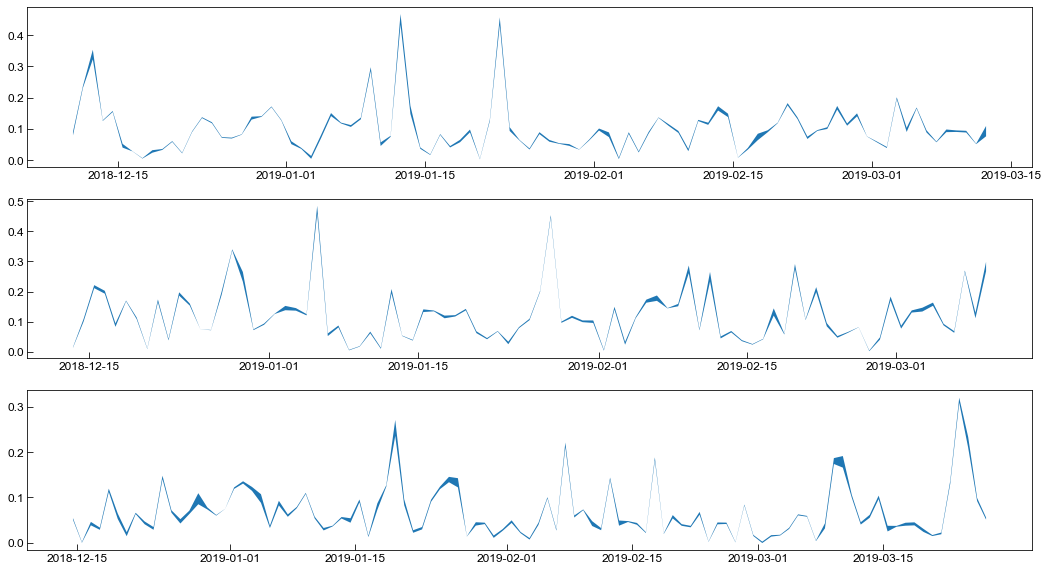

In [21]:
fig,ax=subplots(3)

for i, dat in enumerate([dat_saz_interp,dat_apz_interp,dat_miz_interp]):
    
    ax[i].fill_between(x=dat.time.values, y1=dat.tau_era5.values-dat.tau_se.values, y2=dat.tau_era5.values+dat.tau_se.values)

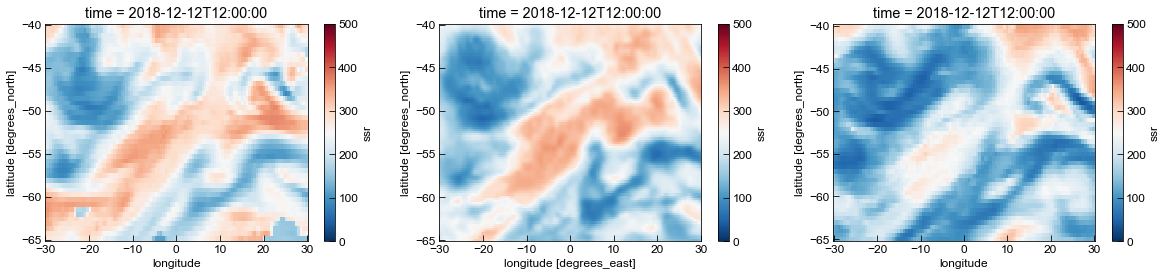

In [66]:
fig, ax = subplots(1,3,figsize=[20, 4])

props = dict(vmin=0, vmax=500, cmap='RdBu_r')
jra55_interp.ssr.isel(time=2).plot(ax=ax[0], **props)
era5_interp .ssr.isel(time=2).plot(ax=ax[1], **props)
merra_interp.ssr.isel(time=2).plot(ax=ax[2], **props)